In [3]:
import time
from ont_fast5_api.fast5_interface import get_fast5_file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def loadReads(f5_file="../../similar_testdata/similar_squiggles.fast5", withMetadata=False):
    '''
        returns list of numpy arrays representing reads as well as dataframe containing reads metadata.
    '''
    print("reading squiggles file...")
    start = time.time()
    reads = []
    if withMetadata:
        ids = []
        length = []
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
                ids.append(read.read_id)
                length.append(len(raw_data))

        z = list(zip(ids, length))
        print(f"Took {time.time()-start} seconds.\n")
        return reads, pd.DataFrame(z, columns=["id", "length"])

    else:
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
        print(f"Took {time.time()-start} seconds.\n")
        return reads

In [4]:
def getClusters(sequence, noOfClusters):
    '''
        calculates n centroids (where n=noOfClusters) around which data is clustered.
    '''

    prevCentroids = [0 for i in range(noOfClusters)]
    centroids = random.sample(sequence, noOfClusters)

    clusters = [[] for i in centroids]
    clustersAggregate = [0 for i in range(noOfClusters)]


    clusterIndex = 0
    distances = [0 for i in range(noOfClusters)]
    done = False

    while not done:
        clusters = [[] for i in centroids]
        clustersAggregate = [0 for i in range(noOfClusters)]
        for component in sequence:
            for i in range(noOfClusters):
                distances[i] = abs(centroids[i] - component)

            clusterIndex = distances.index(min(distances))
            clusters[clusterIndex].append(component)
            clustersAggregate[clusterIndex] += component

        prevCentroids = centroids.copy()
        for i in range(noOfClusters):
            if len(clusters[i]) != 0:
                centroids[i] = clustersAggregate[i]/len(clusters[i])


        if centroids == prevCentroids:
            done = True

    return centroids

In [5]:
def clustNormalise(sequence, noOfClusters, verbose=True):
    '''
        Normalises vector to series of values in range 1-4
    '''
    centroids = getClusters(sequence, noOfClusters)
    centroids.sort()
    print(f"centroids: {centroids}")
    normalValues = [i for i in range(1,noOfClusters+1)]
    newSequence = []
    differences = [0 for i in range(noOfClusters)]
    for component in sequence:
        for i in range(noOfClusters):
            differences[i] = abs(centroids[i]-component)

        newSequence.append(normalValues[differences.index(min(differences))])
    
    return np.array(newSequence, dtype=np.byte)

In [6]:
allSquiggles, metadata = loadReads(withMetadata=True)

reading squiggles file...
Took 14.142686605453491 seconds.



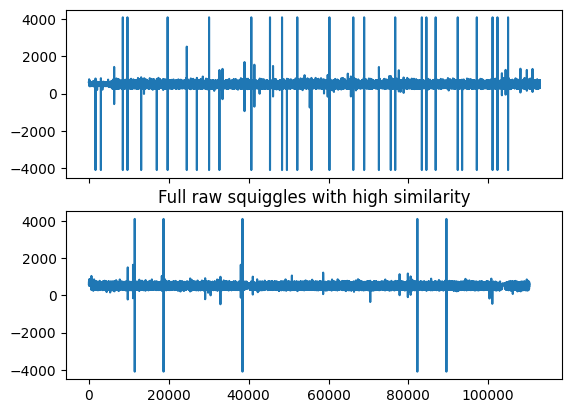

In [7]:
compNo = 2      #no. of squiggles being compared
similarSquiggles = ["995e06ac-fb8c-4c67-a783-223583c215bd", "4d1b87b0-a975-4520-bd89-40e8dd0dd185"]
similarIndices = metadata.index[(metadata['id']==similarSquiggles[0]) | (metadata['id']==similarSquiggles[1])].tolist()

copiedSquiggles = [allSquiggles[similarIndices[i]].copy() for i in range(compNo)]


fig1, axs = plt.subplots(compNo, sharex=True)
plt.title("Full raw squiggles with high similarity")
for i in range(compNo):
    axs[i].plot(copiedSquiggles[i])

plt.show()

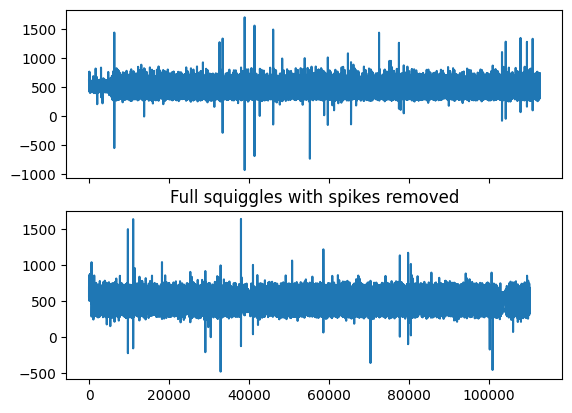

In [9]:
spikeThresh = 2000
removedSpikes = []
for i in range(compNo):
    removedSpikes.append([j for j in copiedSquiggles[i] if abs(j) < spikeThresh])

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("Full squiggles with spikes removed")
for i in range(compNo):
    axs[i].plot(removedSpikes[i])

plt.show()

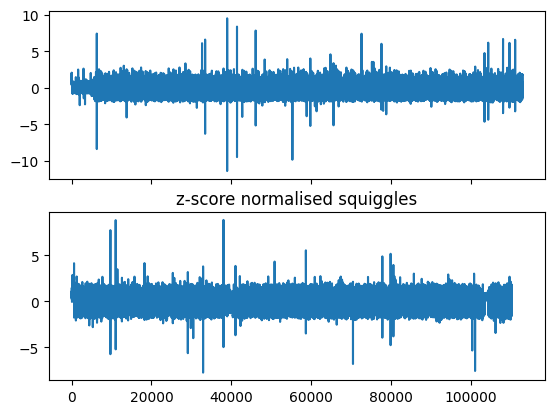

In [20]:
zScoreNormalised = [np.array(i) for i in removedSpikes]       #list holding the 2 squiggles that have been normalised based on the z-score
means = [np.mean(i) for i in zScoreNormalised]
standardDevs = [np.std(i) for i in zScoreNormalised]
for i in range(len(zScoreNormalised)):
    zScoreNormalised[i] = (zScoreNormalised[i] - means[i]) / standardDevs[i]


fig, axs = plt.subplots(compNo, sharex=True)
plt.title("z-score normalised squiggles")
for i in range(compNo):
    axs[i].plot(zScoreNormalised[i])

plt.show()

## Resolution Reduction

In [ ]:
#variables used to control the resolution of the significant values, and clustering approximations, respectively
thresh = 0.15
noOfClusters = 4

### Based on clustering

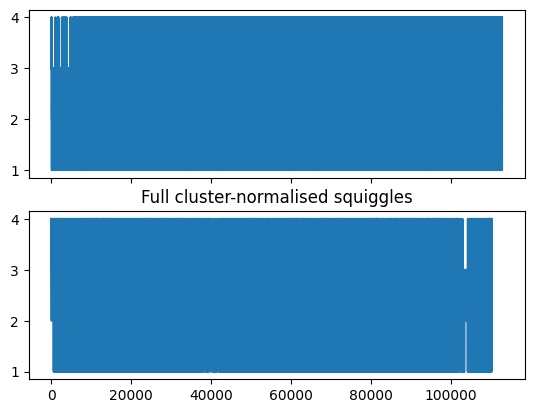

In [44]:
clustered = [clustNormalise(zScoreNormalised[i].tolist(), noOfClusters) for i in range(compNo)]

fig, axs = plt.subplots(compNo, sharex=True)
plt.title("Full cluster-normalised squiggles")
for i in range(compNo):
    axs[i].plot(clustered[i])

plt.show()

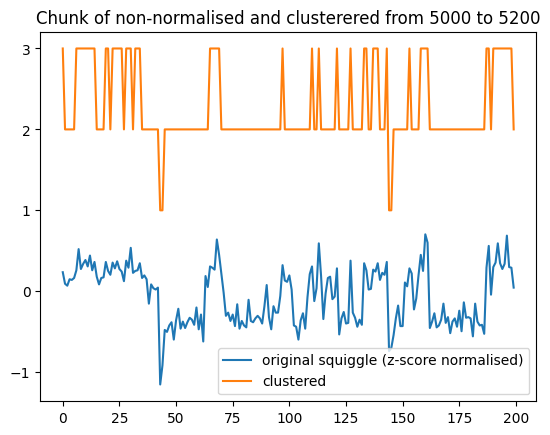

In [45]:
chunkStart = 5000
chunkEnd = chunkStart + 200

fig3 = plt.figure()
plt.title(f"Chunk of non-normalised and clusterered from {chunkStart} to {chunkEnd}")

plt.plot(zScoreNormalised[0][chunkStart:chunkEnd], label="original squiggle (z-score normalised)")
plt.plot(clustered[0][chunkStart:chunkEnd], label="clustered")
plt.legend()
plt.show()

### Based on significant changes in squiggle

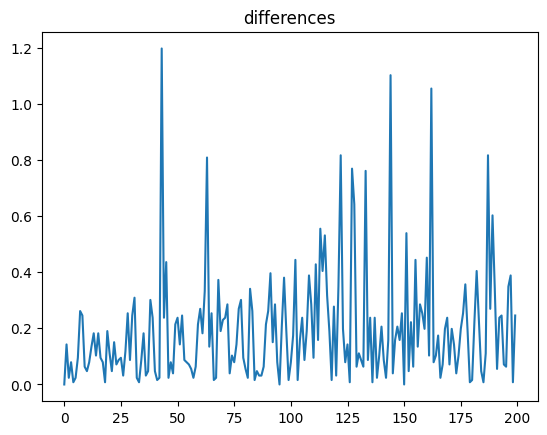

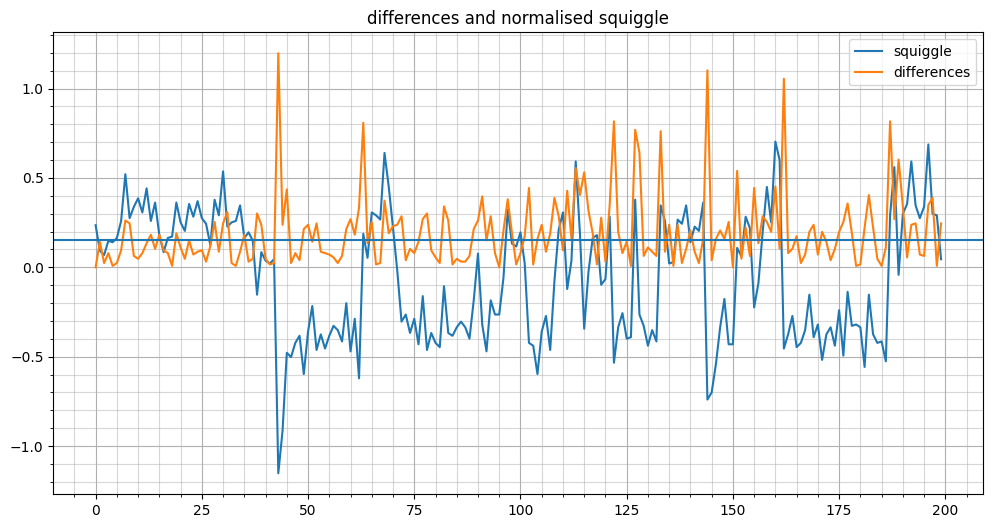

In [57]:
squiggleChunk = zScoreNormalised[0][chunkStart:chunkEnd]

# Initialize an empty list to store moving averages
differences = []

for i in range(len(squiggleChunk)-1):
	 differences.append(abs(squiggleChunk[i+1] - squiggleChunk[i]))

differences.insert(0, 0)		#inserting 0 at 0th index to compensate for shift
plt.title("differences")
plt.plot(differences)

# plotting

#max = 1000
#thresh = 0.15#0.0625+(0.0625*0.1)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("differences and normalised squiggle")
ax.plot(squiggleChunk, label="squiggle")
ax.plot(differences, label="differences")
ax.axhline(thresh)
ax.minorticks_on()
ax.grid(which = "minor", alpha = 0.5)
ax.grid()
ax.legend()

For each entry in the squiggle, if the difference is below the threshold, then just plot the last "significant value":

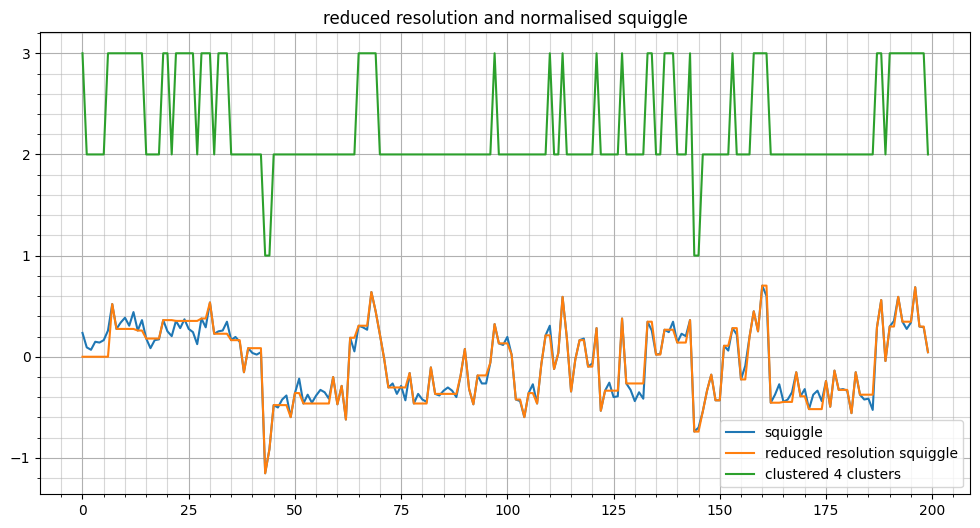

In [60]:
resReducedSquiggle = []
sig = 0
for i in range(len(squiggleChunk)):
    if differences[i] > thresh: sig = squiggleChunk[i]
    resReducedSquiggle.append(sig)


fig, ax = plt.subplots(figsize=(12, 6))
plt.title("reduced resolution and normalised squiggle")
ax.plot(squiggleChunk, label="squiggle")
ax.plot(resReducedSquiggle, label="reduced resolution squiggle")
ax.plot(clustered[0][chunkStart:chunkEnd], label=f"clustered {noOfClusters} clusters")

ax.minorticks_on()
ax.grid(which = "minor", alpha = 0.5)
ax.grid()
ax.legend()